<a href="https://colab.research.google.com/github/1kaiser/EvapoTranspirationNeuralModel/blob/main/Evapo%F0%9F%8C%AA%EF%B8%8F%F0%9F%8C%AB%EF%B8%8F%F0%9F%8C%A7%EF%B8%8F%E2%9B%85%E2%9B%88%EF%B8%8F_transpiration_timeseries_weather_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Timeseries forecasting for weather prediction

**Description:** This notebook demonstrates how to do timeseries forecasting using a LSTM model.

## Climate Data Time-Series

We will be using Jena Climate dataset recorded by the
IMD.
The dataset consists of 7 features such as temperature, humidity etc, recorded once per
Day.

**Location**: Weather Station, Kullu, Himachal Pradesh, India

**Time-frame Considered**: Jan 1, 1984 - December 31, 2012


The table below shows the column names, their value formats, and their description.

Index| Features      |Format             |Description
-----|---------------|-------------------|-----------------------
1    |date     |01.01.2009         |Date reference
2    |Wind speed (m/s)       |1.03               |Wind speed
3    |RH (%)         |93.3               |Relative Humidity is a measure of how saturated the air is with water vapor, the %RH determines the amount of water contained within collection objects.
4    |T max (degC)       |-8.02              |Temperature in Celsius
5    |T min (degC)    |-8.9               |Temperature in Celsius relative to humidity. Dew Point is a measure of the absolute amount of water in the air, the DP is the temperature at which the air cannot hold all the moisture in it and water condenses.
6    |SR (%)         |93.3               |solar radiance
7    |T mean (degC)       |-8.02              |Temperature in Celsius
8    |ET             |0.754162592        |evapotranspiration

## Setup
This example requires TensorFlow 2.3 or higher.

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

train data

In [50]:
file_url = "https://docs.google.com/spreadsheets/d/e/2PACX-1vQuOnK3MRNHupAhDRhLY14guVyFZ90RcD0nbZP1C5oS4_CPXiMNUnJGy7b-hZkS2RcF7GNc0YDXvgkl/pub?gid=1765005939&single=true&output=csv"
df = pd.read_csv(file_url)

In [51]:
df.shape

(10227, 8)

In [52]:
df.head()

,date,Wind speed,RH,T max,T min,SR,T mean,ET
0,01.01.1984,1.24,28.22,5.19,-3.85,13.10,-0.43,1.463283
1,02.01.1984,1.31,29.37,7.01,-4.56,14.18,-0.10,1.566983
2,03.01.1984,1.21,22.67,6.90,-3.61,12.71,0.45,1.573335
3,04.01.1984,1.37,26.63,5.05,-5.46,14.69,-1.49,1.526095
4,05.01.1984,1.56,47.20,1.61,-6.37,8.50,-3.52,1.112412


test data

In [53]:
file_url = "https://docs.google.com/spreadsheets/d/e/2PACX-1vQuOnK3MRNHupAhDRhLY14guVyFZ90RcD0nbZP1C5oS4_CPXiMNUnJGy7b-hZkS2RcF7GNc0YDXvgkl/pub?gid=820464026&single=true&output=csv"
df_newData = pd.read_csv(file_url)

In [54]:
df_newData.shape

(366, 8)

In [55]:
df_newData.head()

,date,Wind speed,RH,T max,T min,SR,T mean,ET
0,01.01.2012,1.20,62.15,5.17,-3.71,10.54,-0.06,1.048840
1,02.01.2012,1.16,63.27,4.93,-3.76,10.91,-0.17,1.029404
2,03.01.2012,1.29,59.03,4.60,-5.15,12.84,-1.07,1.111735
3,04.01.2012,0.99,74.59,2.08,-4.81,5.83,-1.80,0.691825
4,05.01.2012,1.31,82.26,2.53,-4.52,8.17,-1.97,0.701882


## Raw Data Visualization

To give us a sense of the data we are working with, each feature has been plotted below.
This shows the distinct pattern of each feature over the time period from 1984 to 2012.
It also shows where anomalies are present, which will be addressed during normalization.

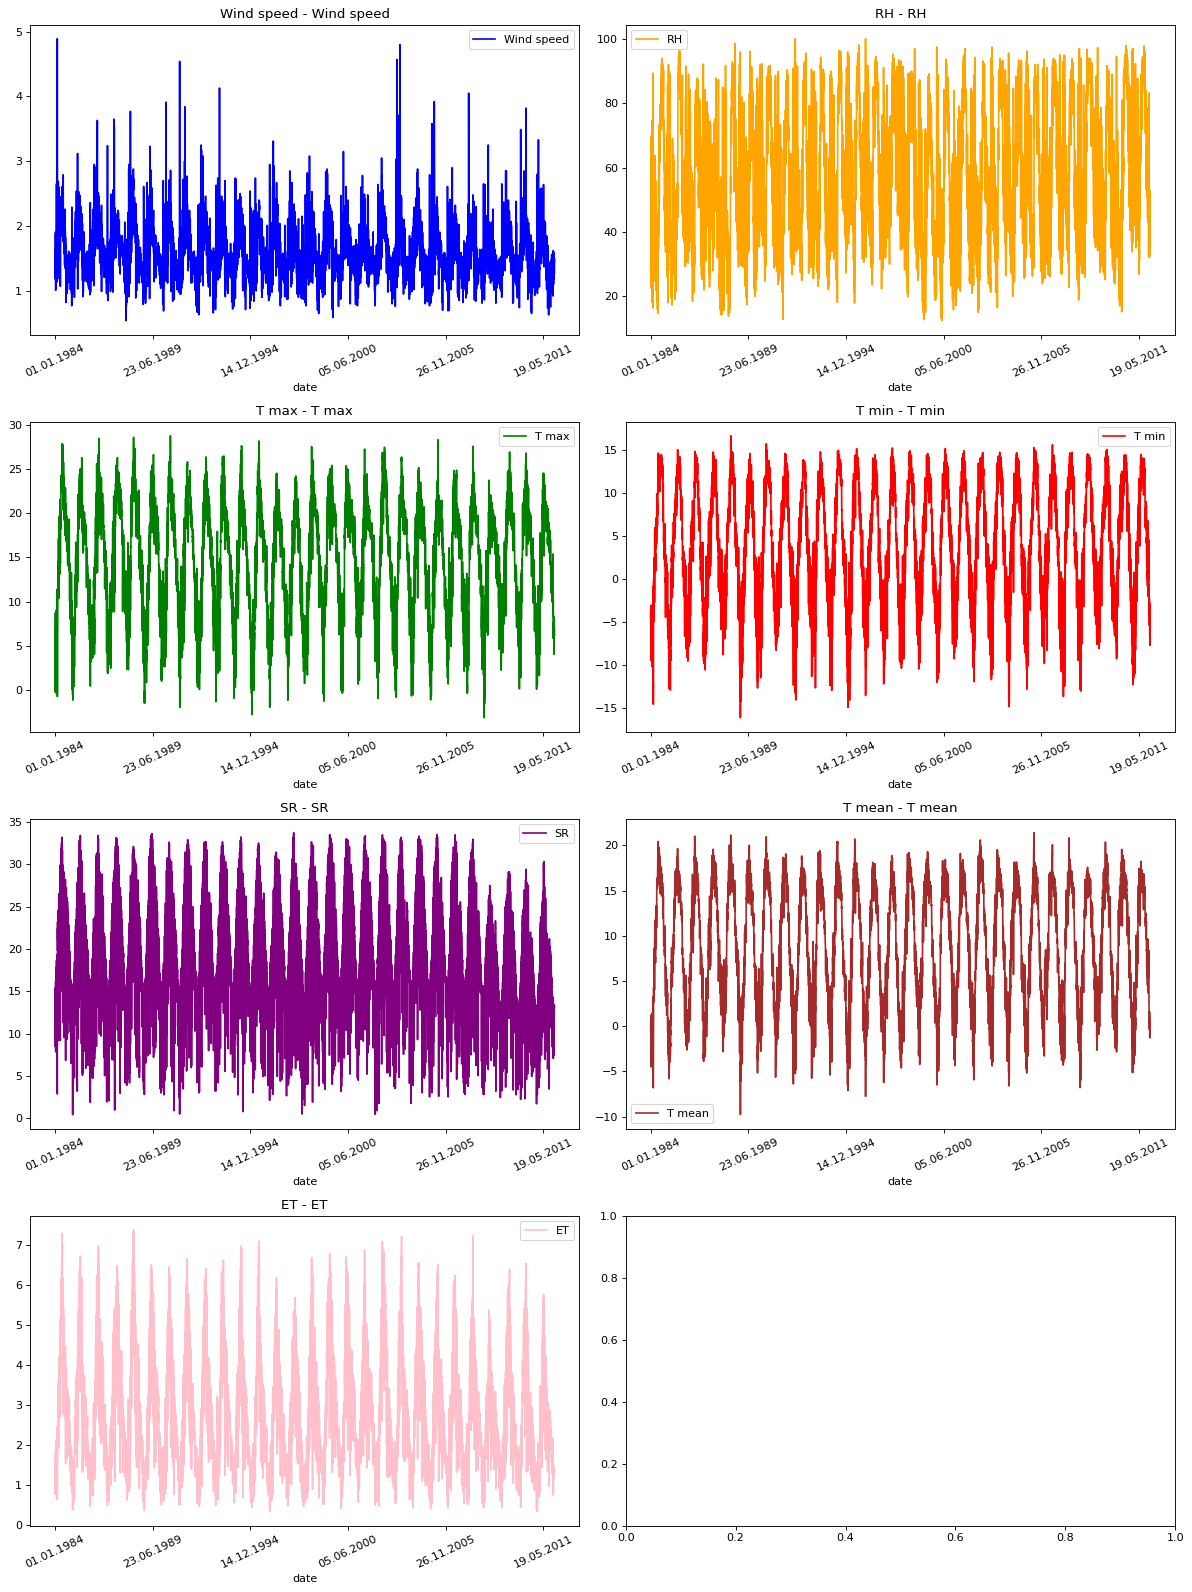

In [56]:
titles = [
    "Wind speed",
    "RH",
    "T max",
    "T min",
    "SR",
    "T mean",
    "ET",
]

feature_keys = [
    "Wind speed",
    "RH",
    "T max",
    "T min",
    "SR",
    "T mean",
    "ET",
]

colors = [
    "blue",
    "orange",
    "green",
    "red",
    "purple",
    "brown",
    "pink",
]

date_time_key = "date"


def show_raw_visualization(data):
    time_data = data[date_time_key]
    fig, axes = plt.subplots(
        nrows=4, ncols=2, figsize=(15, 20), dpi=80, facecolor="w", edgecolor="k"
    )
    for i in range(len(feature_keys)):
        key = feature_keys[i]
        c = colors[i % (len(colors))]
        t_data = data[key]
        t_data.index = time_data
        t_data.head()
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            color=c,
            title="{} - {}".format(titles[i], key),
            rot=25,
        )
        ax.legend([titles[i]])
    plt.tight_layout()


show_raw_visualization(df)

This heat map shows the correlation between different features.

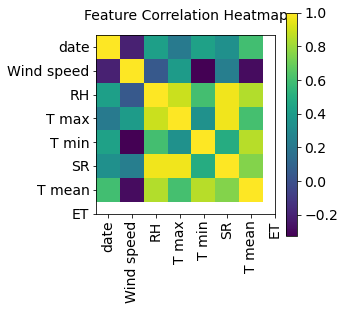

In [57]:

def show_heatmap(data):
    plt.matshow(data.corr())
    plt.xticks(range(data.shape[1]), data.columns, fontsize=14, rotation=90)
    plt.gca().xaxis.tick_bottom()
    plt.yticks(range(data.shape[1]), data.columns, fontsize=14)

    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title("Feature Correlation Heatmap", fontsize=14)
    plt.show()


show_heatmap(df)


## Data Preprocessing

Here we are picking ~10227 * 8 data points for training. Observation is recorded every
day. We will resample one point per day since no
drastic change is expected within 1 day. We do this via the `sampling_rate`
argument in `timeseries_dataset_from_array` utility.

We are tracking data from past 365 timestamps (365/1=365 days). This data will be
used to predict the evapotranspiration after 30 timestamps (30/1=36 days).

Since every feature has values with
varying ranges, we do normalization to confine feature values to a range of `[0, 1]` before
training a neural network.
We do this by subtracting the mean and dividing by the standard deviation of each feature.

71.5 % of the data will be used to train the model, i.e. 71% of 10227 rows. `split_fraction` can
be changed to alter this percentage.

The model is shown data for first 1984 to 2011 days i.e. 365 * (2011-1984) observations, that are sampled every
hour. The evapotranspiration after 30 (30 days * 1 observation per day) observation will be
used as a label.

In [71]:
split_fraction = 0.715
train_split = int(split_fraction * int(df.shape[0]))
step = 6

past = 365
future = 30
learning_rate = 0.001
batch_size = 256
epochs = 100


def normalize(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return (data - data_mean) / data_std


We can see from the correlation heatmap, few parameters like Relative Humidity and
Specific Humidity are redundant. Hence we will be using select features, not all.

In [59]:
titles

['Wind speed', 'RH', 'T max', 'T min', 'SR', 'T mean', 'ET']

In [60]:
print(
    "The selected parameters are:",
    ", ".join([titles[i] for i in [0, 1, 2, 3, 4, 5]]),
)
selected_features = [feature_keys[i] for i in [0, 1, 2, 3, 4, 5]]
features = df[selected_features]
features.index = df[date_time_key]
features.head()

features = normalize(features.values, train_split)
features = pd.DataFrame(features)
features.head()

train_data = features.loc[0 : train_split - 1]
val_data = features.loc[train_split:]

The selected parameters are: Wind speed, RH, T max, T min, SR, T mean


# Training dataset

The training dataset labels starts from the 395th observation (365 + 30).

In [61]:
start = past + future
end = start + train_split

x_train = train_data[[i for i in range(6)]].values
y_train = features.iloc[start:end][[1]]

sequence_length = int(past / step)

The `timeseries_dataset_from_array` function takes in a sequence of data-points gathered at
equal intervals, along with time series parameters such as length of the
sequences/windows, spacing between two sequence/windows, etc., to produce batches of
sub-timeseries inputs and targets sampled from the main timeseries.

In [62]:
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)

## Validation dataset

The validation dataset must not contain the last 395 rows as we won't have label data for
those records, hence 395 must be subtracted from the end of the data.

The validation label dataset must start from 395 after train_split, hence we must add
past + future (395) to label_start.

In [63]:
label_start = train_split + past + future
features.iloc[label_start:][[1]]

,1
7707,1.777345
7708,2.082820
7709,1.712877
7710,1.830406
7711,1.195651
...,...
10222,-0.510254
10223,-0.456697
10224,-0.790439
10225,-0.716054


In [64]:
x_end = len(val_data) - past - future

label_start = train_split + past + future

x_val = val_data.iloc[:x_end][[i for i in range(6)]].values
y_val = features.iloc[label_start:][[1]]

dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)


for batch in dataset_train.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (256, 60, 6)
Target shape: (256, 1)


## Training

In [65]:
inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_out = keras.layers.LSTM(32)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 60, 6)]           0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                4992      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 5,025
Trainable params: 5,025
Non-trainable params: 0
_________________________________________________________________


We'll use the `ModelCheckpoint` callback to regularly save checkpoints, and
the `EarlyStopping` callback to interrupt training when the validation loss
is not longer improving.

In [72]:
path_checkpoint = "model_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[es_callback, modelckpt_callback],
)

Epoch 1/100
28/28 [==============================] - ETA: 0s - loss: 0.4834
Epoch 1: val_loss improved from inf to 0.51863, saving model to model_checkpoint.h5
28/28 [==============================] - 2s 74ms/step - loss: 0.4834 - val_loss: 0.5186
Epoch 2/100
28/28 [==============================] - ETA: 0s - loss: 0.4792
Epoch 2: val_loss improved from 0.51863 to 0.51693, saving model to model_checkpoint.h5
28/28 [==============================] - 2s 75ms/step - loss: 0.4792 - val_loss: 0.5169
Epoch 3/100
28/28 [==============================] - ETA: 0s - loss: 0.4759
Epoch 3: val_loss improved from 0.51693 to 0.51609, saving model to model_checkpoint.h5
28/28 [==============================] - 2s 73ms/step - loss: 0.4759 - val_loss: 0.5161
Epoch 4/100
28/28 [==============================] - ETA: 0s - loss: 0.4733
Epoch 4: val_loss improved from 0.51609 to 0.51566, saving model to model_checkpoint.h5
28/28 [==============================] - 2s 74ms/step - loss: 0.4733 - val_loss: 0.5

We can visualize the loss with the function below. After one point, the loss stops
decreasing.

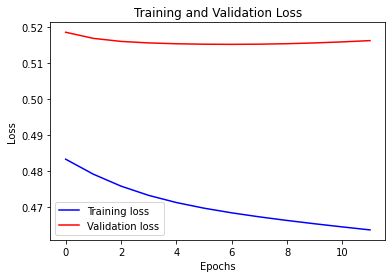

In [73]:

def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Loss")

## Prediction

The trained model above is now able to make predictions for 5 sets of values from
validation set.

In [74]:
df_newData[selected_features]


,Wind speed,RH,T max,T min,SR,T mean
0,1.20,62.15,5.17,-3.71,10.54,-0.06
1,1.16,63.27,4.93,-3.76,10.91,-0.17
2,1.29,59.03,4.60,-5.15,12.84,-1.07
3,0.99,74.59,2.08,-4.81,5.83,-1.80
4,1.31,82.26,2.53,-4.52,8.17,-1.97
...,...,...,...,...,...,...
361,0.76,52.56,7.40,-0.35,6.19,2.33
362,1.74,56.31,5.36,-3.11,7.47,0.72
363,1.52,67.44,5.04,-4.31,12.16,-0.66
364,1.33,62.47,6.36,-4.52,12.39,-0.05


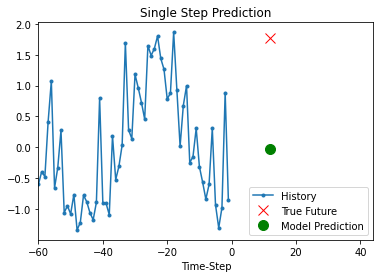

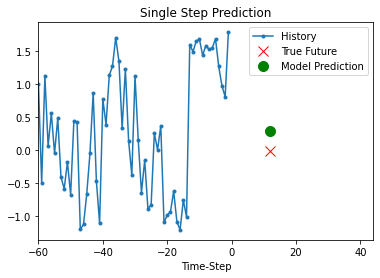

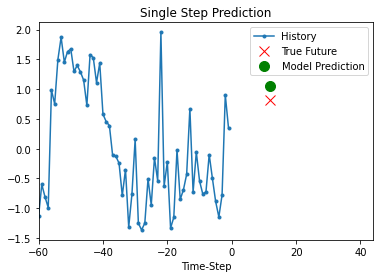

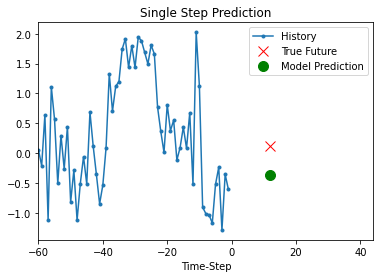

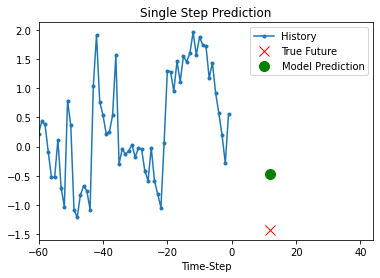

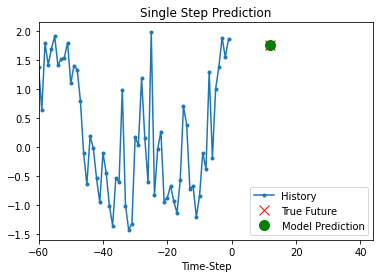

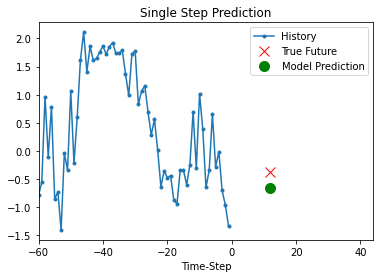

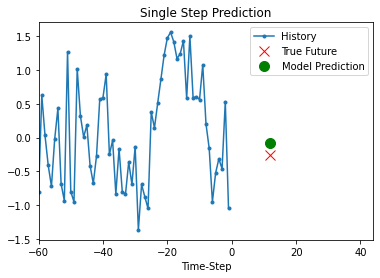

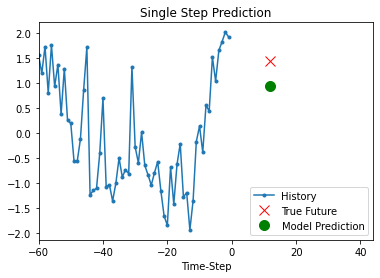

In [77]:

def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 10) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return


for x, y in dataset_val.take(10):
    show_plot(
        [x[0][:, 1].numpy(), y[0].numpy(), model.predict(x)[0]],
        12,
        "Single Step Prediction",
    )

In [70]:
plt.show()